# Faster RC-NN Demo for Object Detection


## Install dependencies

In [197]:
%pip install torch torchvision
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [198]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## set pretrained model with ResNet50 backbone

In [199]:
model = fasterrcnn_resnet50_fpn(weights='DEFAULT', backbone_weights='DEFAULT')

# Ensure the model is in evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Load an example image and convert it to a tensor

In [200]:
# Load an image
image_path = 'example.jpg'
image = Image.open(image_path).convert("RGB")

# Define the transform
transform = T.Compose([
    T.ToTensor()
])

# Apply the transform
image_tensor = transform(image)


## Register Hooks to capture intermediate results

In [201]:
# Hook to capture the feature maps
feature_maps = []  # Dictionary to store feature maps for each layer
def feature_hook(module, input, output):
    feature_maps.append(output)
feature_hook_handles = []
for layer in [model.backbone.body.layer1,
              model.backbone.body.layer2,
              model.backbone.body.layer3,
              model.backbone.body.layer4]:
    handle = layer.register_forward_hook(feature_hook)
    feature_hook_handles.append(handle)


# region proposal hook before roi pooling
rpn_proposals = None
def rpn_hook(module, input, output):
    global rpn_proposals
    rpn_proposals = output
rpn_handle = model.rpn.register_forward_hook(rpn_hook)


## Run the model with hooks

In [202]:


# Run the model on the image
with torch.no_grad():
    outputs = model([image_tensor])


## Remove the hooks

In [203]:

# Remove the hooks
for handle in feature_hook_handles:
    handle.remove()

# Remove the rpn hook
rpn_handle.remove()


## Visualize the results

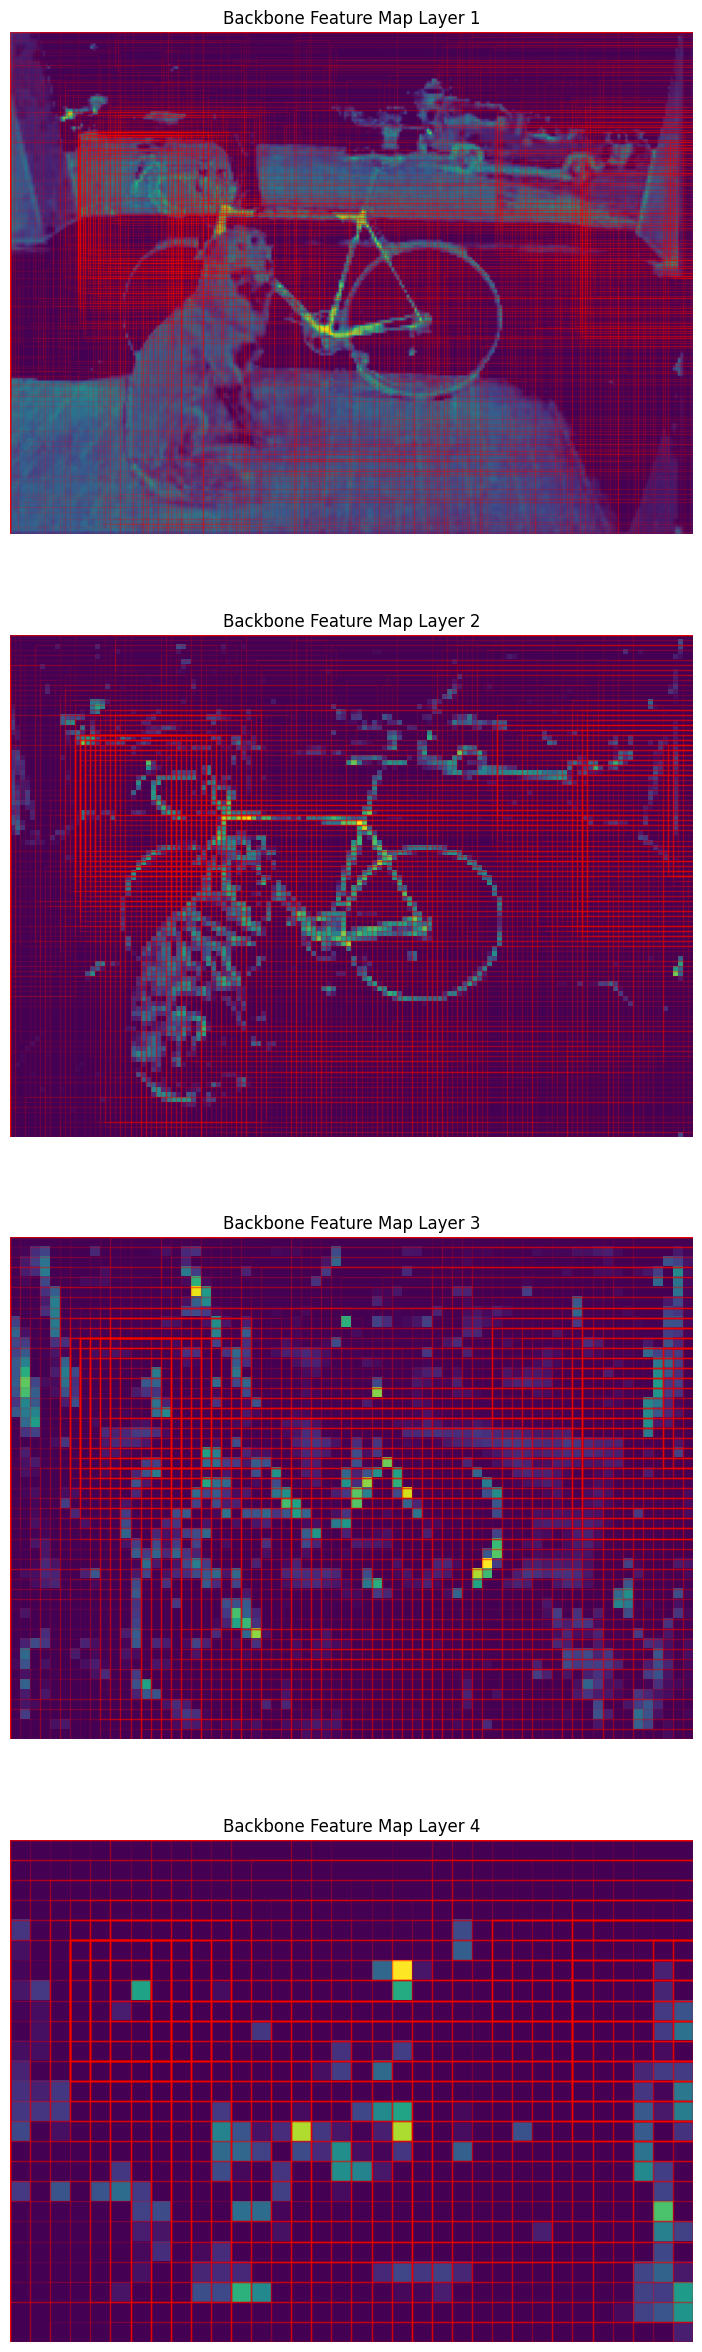

In [204]:

# Visualize the first channel of the final feature map


def visualize_feature_map(feature_maps, rpn_proposals):
    # visualize the feature maps in one row next to each other
    columns = 1
    rows = len(feature_maps)
    fig, ax = plt.subplots(rows, columns, figsize=(30, 30))
    for i, feature_map in enumerate(feature_maps):
        ax[i].imshow(feature_map[0, 0].cpu().numpy(), cmap='viridis')
        ax[i].set_title(f'Backbone Feature Map Layer {i + 1}')
        ax[i].axis('off')

    for proposal in rpn_proposals[0][0]:
        for axis in ax:
            x_range = abs(axis.get_xlim()[1] - axis.get_xlim()[0])
            y_range = abs(axis.get_ylim()[0] - axis.get_ylim()[1])
            img_width = image_tensor.shape[-1]
            img_height = image_tensor.shape[-2]
            x, y, w, h = proposal.cpu().numpy()
            # map the coordinates to the feature map
            x = int(x / img_width * x_range) - 0.5
            y = int(y / img_height * y_range) - 0.5
            w = int(w / img_width * x_range)
            h = int(h / img_height * y_range)

            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=(1, 0, 0, 0.1), facecolor='none')
            axis.add_patch(rect)

    plt.show()


visualize_feature_map(feature_maps, rpn_proposals)

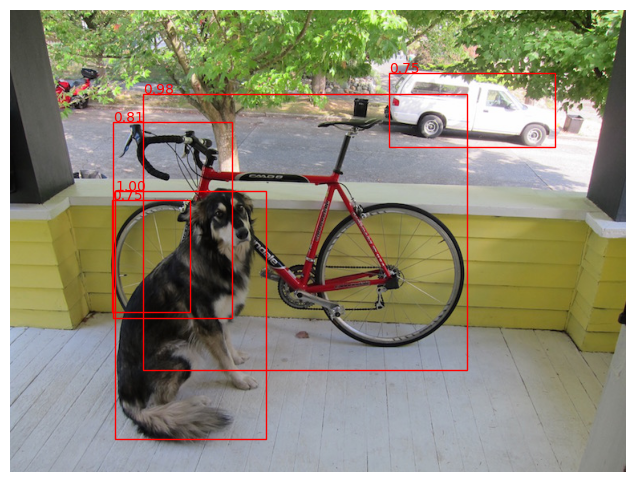

In [205]:
def visualize_predictions(image, outputs, threshold=0.5):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image)

    for score, box in zip(outputs[0]['scores'], outputs[0]['boxes']):
        if score > threshold:
            score_value = score.item()  # Convert score tensor to float
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.text(box[0], box[1], f'{score_value:.2f}', color='red')
            ax.add_patch(rect)

    ax.axis('off')
    plt.show()

visualize_predictions(image, outputs, threshold=0.7)